In [36]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
ground_truth = pd.read_csv('CSVs/extraction/positions_with_ground_truth.csv')
ground_truth.head()

,Subgroup,Position,Max_Value,Range,Target_Start_pos,Target_Stop_pos,Input_Sequence,Predicted_Start_pos,Predicted_Stop_pos
0,Ada_1_209398-209425-forward,263,913.0,"range(256, 271)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,256,270
1,Ada_1_2145603-2145630-reverse,157,511.0,"range(150, 165)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,150,164
2,Ada_1_2308475-2308502-reverse,43,687.0,"range(36, 51)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,36,50
3,Ada_2_209398-209425-forward,24,121.0,"range(17, 32)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,17,31
4,Ada_2_2145603-2145630-reverse,386,96.0,"range(379, 394)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,379,393


In [3]:
streme_results = pd.read_csv('CSVs/stage_1/streme_sites.csv')
streme_results = streme_results.iloc[:, 1:]
streme_results.head()

,File_name,Site,Score,Width
0,TyrR,ATTGACGCAGGGATG,0.0007,15
1,TyrR,ATTGACGCAGGCATG,0.0007,15
2,TyrR,ATTGGCGCAGGGATG,0.0007,15
3,TyrR,ATTGGCGCAGGCATG,0.0007,15
4,TyrR,CGATAAGATGAATAT,0.0007,15


In [4]:
ground_truth['Target_Motif'] = ground_truth.apply(lambda row: row['Input_Sequence'][row['Predicted_Start_pos']:row['Predicted_Stop_pos']], axis=1)
ground_truth

,Subgroup,Position,Max_Value,Range,Target_Start_pos,Target_Stop_pos,Input_Sequence,Predicted_Start_pos,Predicted_Stop_pos,Target_Motif
0,Ada_1_209398-209425-forward,263,913.0,"range(256, 271)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,256,270,CATGCCCATCGGAA
1,Ada_1_2145603-2145630-reverse,157,511.0,"range(150, 165)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,150,164,CCCTCCGCTGTTCA
2,Ada_1_2308475-2308502-reverse,43,687.0,"range(36, 51)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,36,50,GTCCCAGACTAATA
3,Ada_2_209398-209425-forward,24,121.0,"range(17, 32)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,17,31,CAAGGCAGAGGTTT
4,Ada_2_2145603-2145630-reverse,386,96.0,"range(379, 394)",200,228,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,379,393,AACGTGGTTGACAC
...,...,...,...,...,...,...,...,...,...,...
2227,XylR_2_3728622-3728637-forward,115,821.0,"range(108, 123)",200,216,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,108,122,TATTATGTAAGTAT
2228,XylR_3_3728472-3728487-reverse,99,142.0,"range(92, 107)",200,216,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,92,106,TCAAACTGGATCAT
2229,XylR_3_3728622-3728637-forward,169,142.0,"range(162, 177)",200,216,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,162,176,CAATCGGCTTCACA
2230,XylR_5_3728472-3728487-reverse,150,80.0,"range(143, 158)",200,216,TTCATCAAATGAATGGTCAAGGCAGAGGTTTTCGTCGTCCCAGACT...,143,157,ATGCTATCCCTCCG


TRY 

In [31]:
def find_similar_motifs(streme_results, ground_truth):
    similar_motifs = {}

    for _, row_gt in ground_truth.iterrows():
        target_motif = row_gt['Target_Motif']
        for _, row_sr in streme_results.iterrows():
            site = row_sr['Site']
            differences = sum(s != t for s, t in zip(target_motif, site))
            if differences <= 7:
                similar_motifs[target_motif] = differences
                break

    return similar_motifs


In [32]:
def add_weights_with_similarity(ground_truth, streme_results):
    # Initialize the 'Weights' column to 1
    ground_truth['Weights'] = 1

    # Define the weights for different levels of similarity
    similarity_weights = {0:1, 1: 0.9, 2: 0.8, 3: 0.7, 4: 0.6, 5: 0.4, 6: 0.2, 7: 0.1}

    # Get the unique file names in streme_results
    unique_file_names = streme_results['File_name'].str.split('_', n=1, expand=True)[0].unique()

    # Iterate over each unique file name
    for file_name in unique_file_names:
        # Filter the streme_results for the current file name
        file_results = streme_results[streme_results['File_name'].str.startswith(file_name)]

        # Filter the ground_truth based on the file name part
        filtered_ground_truth = ground_truth[ground_truth['Subgroup'].str.startswith(file_name)]

        # Find similar motifs using the find_similar_motifs function
        similar_motifs = find_similar_motifs(file_results, filtered_ground_truth)

        # Iterate over each row in the filtered ground_truth
        for _, row in filtered_ground_truth.iterrows():
            # Check if the target motif is in the similar motifs
            if row['Target_Motif'] in similar_motifs:
                # Get the number of differences
                differences = similar_motifs[row['Target_Motif']]

                # Add the corresponding weight based on the number of differences
                weight = similarity_weights.get(differences, 0)
                ground_truth.loc[_, 'Weights'] += weight

    return ground_truth


In [33]:
updated_ground_truth = add_weights_with_similarity(ground_truth, streme_results)

In [34]:
updated_ground_truth.Weights.unique()

array([1.1, 1. , 1.2, 2. , 1.4, 1.6])

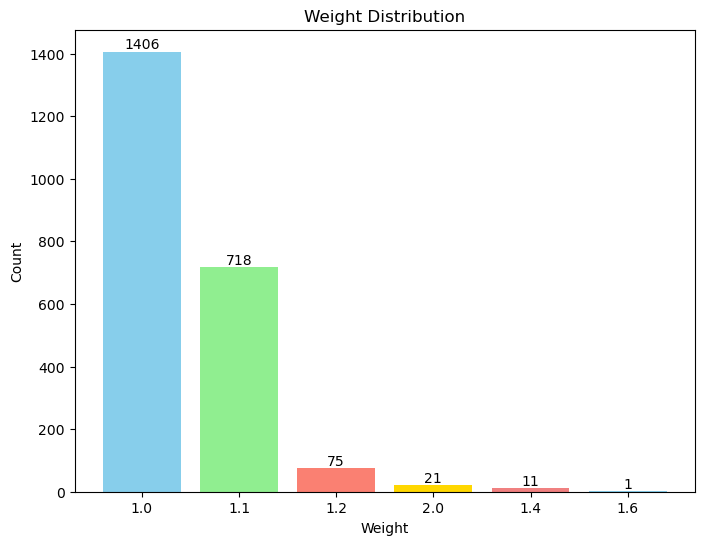

In [39]:
def plot_weight_distribution(updated_ground_truth):
    weight_counts = updated_ground_truth['Weights'].value_counts()

    colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral']
    bar_width = 0.8
    x_indices = np.arange(len(weight_counts))

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(x_indices, weight_counts.values, color=colors, width=bar_width)

    ax.set_xticks(x_indices)
    ax.set_xticklabels(weight_counts.index)

    ax.set_xlabel('Weight')
    ax.set_ylabel('Count')
    ax.set_title('Weight Distribution')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

    plt.show()

plot_weight_distribution(updated_ground_truth)

In [40]:
updated_ground_truth.to_csv('CSVs/extraction/weighted_ground_truth.csv', index=False)